In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import tensorflow.keras.layers as layers
from sklearn.model_selection import KFold
import scipy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [2]:
BATCH_SIZE = 256
FIG_SIZE = (16, 10)

In [3]:
df = pd.read_pickle('train1.pkl')
df

,AvgP1,AvgT,AvgH,AvgP2,AvgP3,DateTime,holidays,dayofweek
DateTime,,,,,,,,
2017-02-06 00:00:00,0.0,3.500000,98.599998,0.0,0.0,2017-02-06 00:00:00,0,0
2017-02-06 17:00:00,81.0,9.500000,84.599998,80.0,69.0,2017-02-06 17:00:00,0,0
2017-02-06 17:15:00,0.0,9.200000,86.800003,0.0,0.0,2017-02-06 17:15:00,0,0
2017-02-06 17:30:00,86.0,8.700000,87.900002,0.0,0.0,2017-02-06 17:30:00,0,0
2017-02-06 17:45:00,0.0,7.650000,89.849998,82.0,0.0,2017-02-06 17:45:00,0,0
...,...,...,...,...,...,...,...,...
2019-04-10 14:30:00,82.0,15.700000,65.500000,81.0,-22.0,2019-04-10 14:30:00,0,2
2019-04-10 14:45:00,71.0,16.900000,62.349998,71.0,6.0,2019-04-10 14:45:00,0,2
2019-04-10 15:00:00,71.0,17.400000,57.900002,70.0,29.0,2019-04-10 15:00:00,0,2


In [4]:
def get_windows(x, win_in=100, win_out=16):
    y = np.vstack([x[i+win_in:i+win_in+win_out] for i in range(len(x)-win_in-win_out)])
    x = np.vstack([x[i:i+win_in] for i in range(len(x)-win_in-win_out)])
    return x, y
def holidays_score(x, win_in=100, win_out=16):
    return np.vstack([np.mean(x[i+win_in:i+win_in+win_out]) > 0.5 for i in range(len(x)-win_in-win_out)]).astype('int8')
def normalize(x, mi, sigma):
    return (x.copy()-mi) / sigma

In [17]:
def get_model(units=[32, 32]):
    inp = layers.Input(shape=(None, 1))
    x = inp
    for unit in units:
        x = layers.Bidirectional(layers.LSTM(unit, return_sequences=True, dropout=0.1))(x)
        x = layers.LayerNormalization()(x)
    x = layers.LSTM(1, return_sequences=True)(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    
    opt = tf.keras.optimizers.Adam(1e-3)
    loss = PrefixParse(tf.losses.MSE)
    
    model.compile(opt, loss, metrics=[PrefixParse(tf.keras.metrics.MSE, name='mse'),
                                      PrefixParse(tf.keras.metrics.MAPE, name='mape'),
                                      PrefixParse(tf.keras.metrics.MAE, name='mae')])
    return model


def PrefixParse(funct, name=None, **karg):
    @tf.function
    def f(y_true, y_pred):
        win_out = y_true.shape[1]
        y_pred = y_pred[:,-win_out:,:]
        return funct(y_pred, y_true, **karg)
    if name is None:
        name = funct.__name__
    f.__name__ = name
    return f

In [6]:
x, y = get_windows(df['AvgP2'])

In [7]:
x = np.expand_dims(x, axis=-1)
y = np.expand_dims(y, axis=-1)
x.shape, y.shape

((76208, 100, 1), (76208, 16, 1))

In [8]:
holidays = holidays_score(df['holidays'])
holidays.shape

(76208, 1)

In [25]:
get_model().summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 64)          8704      
_________________________________________________________________
layer_normalization_13 (Laye (None, None, 64)          128       
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
layer_normalization_14 (Laye (None, None, 64)          128       
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 1)           264       
Total params: 34,056
Trainable params: 34,056
Non-trainable params: 0
_________________________________________________

In [18]:
kf = KFold(n_splits=2)
ans = {}
for idx, (train_index, test_index) in enumerate(kf.split(x)):
    print('run:', idx)
    model = get_model()
    mi = np.mean(x[train_index])
    sigma = np.std(x[train_index])
    x_train = normalize(x[train_index], mi, sigma)
    y_train = normalize(y[train_index], mi, sigma)
    x_test = normalize(x[test_index], mi, sigma)
    y_test = normalize(y[test_index], mi, sigma)
    
    hist = model.fit(x_train, y_train,
             batch_size=BATCH_SIZE,
             epochs=100,
             validation_data=(x_test, y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)]).history
    res_train = np.squeeze(model.predict(x_train, batch_size=2*BATCH_SIZE)[:,-y_train.shape[1]:,:] - y_train)
    res_test  = np.squeeze(model.predict(x_test, batch_size=2*BATCH_SIZE)[:,-y_train.shape[1]:,:] - y_test)
    
    
    for h in hist:
        if idx == 0:
            ans[h] = [hist[h]]
        else:
            ans[h].append(hist[h])
    mean = np.mean(res_train, axis=0)
    cov = np.cov(res_train, rowvar=0)
    prob = scipy.stats.multivariate_normal.pdf(res_test, mean=mean, cov=cov)
    if idx == 0:
        ans['mean'] = [mean]
        ans['cov'] = [cov]
        ans['prob'] = [prob]
        ans['res_test'] = [res_test]
        ans['x_test'] = [x_test]
        ans['h_test'] = [holidays[test_index]]
    else:
        ans['mean'].append(mean)
        ans['cov'].append(cov)
        ans['prob'].append(prob)
        ans['res_test'].append(res_test)
        ans['x_test'].append(x_test)
        ans['h_test'].append(holidays[test_index])
    print()

run: 0
Epoch 1/100
149/149 [==============================] - 13s 85ms/step - loss: 0.4311 - mse: 0.4311 - mape: 6134.8237 - mae: 0.4780 - val_loss: 0.3311 - val_mse: 0.3311 - val_mape: 257.0661 - val_mae: 0.3686
Epoch 2/100
149/149 [==============================] - 10s 70ms/step - loss: 0.2476 - mse: 0.2476 - mape: 224.4001 - mae: 0.3096 - val_loss: 0.2926 - val_mse: 0.2926 - val_mape: 343.1793 - val_mae: 0.3366
Epoch 3/100
149/149 [==============================] - 11s 71ms/step - loss: 0.2322 - mse: 0.2322 - mape: 333.7553 - mae: 0.2895 - val_loss: 0.2838 - val_mse: 0.2838 - val_mape: 250.6287 - val_mae: 0.3294
Epoch 4/100
149/149 [==============================] - 10s 70ms/step - loss: 0.2269 - mse: 0.2269 - mape: 293.4174 - mae: 0.2816 - val_loss: 0.2856 - val_mse: 0.2856 - val_mape: 360.8859 - val_mae: 0.3297
Epoch 5/100
149/149 [==============================] - 10s 70ms/step - loss: 0.2228 - mse: 0.2228 - mape: 207.1946 - mae: 0.2759 - val_loss: 0.2838 - val_mse: 0.2838 - val_

In [19]:
print(f"mse: {[min(l) for l in ans['mse']]} - {[min(l) for l in ans['val_mse']]}")
print(f"mape: {[min(l) for l in ans['mape']]} - {[min(l) for l in ans['val_mape']]}")
print(f"mae: {[min(l) for l in ans['mae']]} - {[min(l) for l in ans['val_mae']]}")

mse: [0.21609963476657867, 0.23985667526721954] - [0.2761669456958771, 0.2233251929283142]
mape: [176.67706298828125, 175.0458984375] - [181.6134796142578, 160.1486053466797]
mae: [0.26622873544692993, 0.2942480146884918] - [0.3186439275741577, 0.2761278748512268]


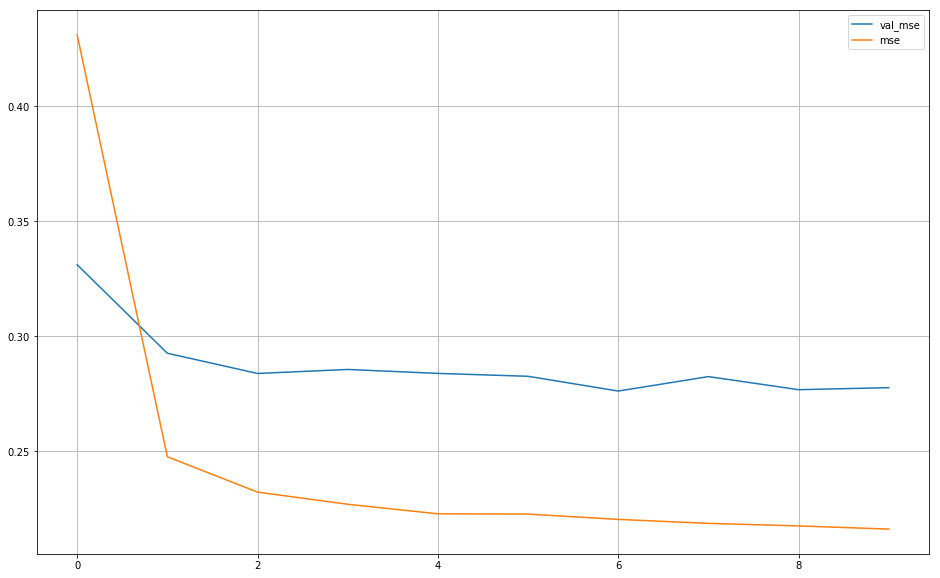

In [20]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot(ans['val_mse'][0], label='val_mse')
ax.plot(ans['mse'][0], label='mse')

ax.grid()
ax.legend()
plt.show()

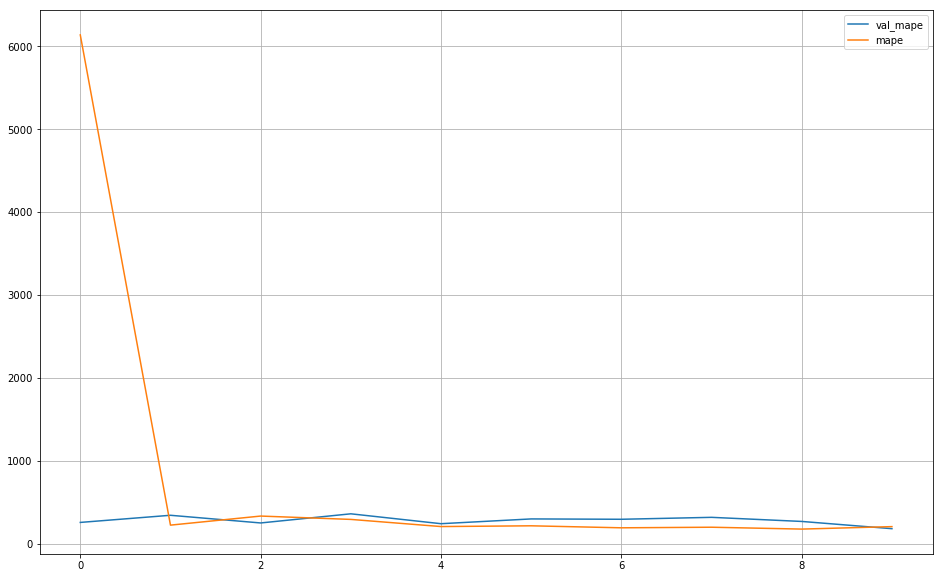

In [21]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot(ans['val_mape'][0], label='val_mape')
ax.plot(ans['mape'][0], label='mape')

ax.grid()
ax.legend()
plt.show()

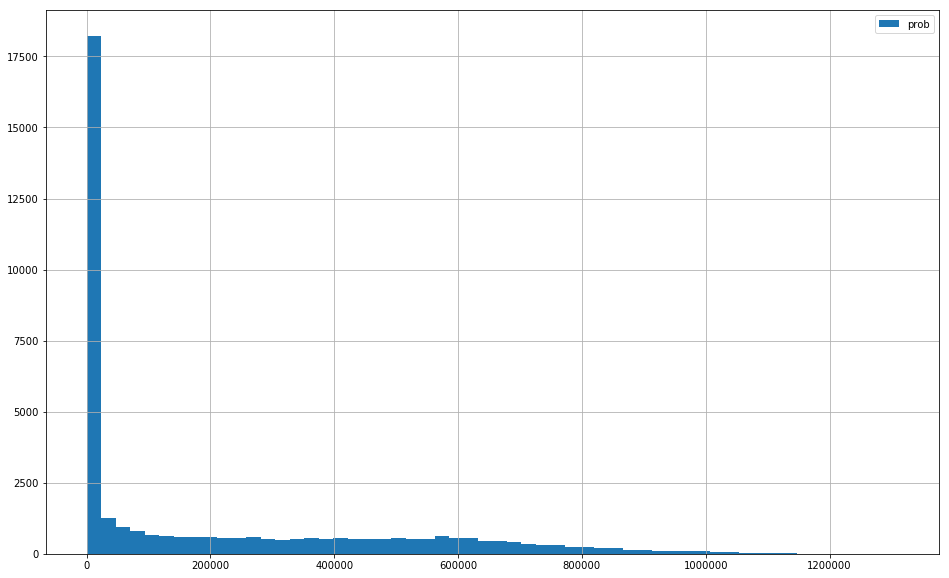

In [22]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.hist(np.clip(ans['prob'][0], 0, 1e8), label='prob', bins='auto')

ax.grid()
ax.legend()
plt.show()

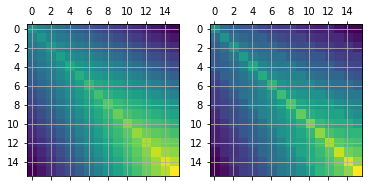

In [23]:
#convariance matrix
fig, axs = plt.subplots(ncols=len(ans['cov']))
for ax, cov in zip(axs, ans['cov']):
    ax.matshow(cov)
    ax.grid()
plt.show()

In [24]:
# precision - recall - F0.1 - accuracy
met = {'run':[], 'threshold': [], 'precision': [], 'recall':[], 'F0.1-score':[], 'accuracy':[],}
for idx, (y_true, prob) in enumerate(zip(ans['h_test'], ans['prob'])):
    thresholds = np.sort(np.random.choice(prob, size=20, replace=False)) # [-20:]
    for i in thresholds:
        threshold  = i
        y_pred = (prob < threshold).astype('int8')
        met['run'].append(idx)
        met['threshold'].append(threshold)
        met['accuracy'].append(metrics.accuracy_score(y_true, y_pred))
        met['recall'].append(metrics.recall_score(y_true, y_pred))
        met['F0.1-score'].append(metrics.fbeta_score(y_true, y_pred, beta=0.1))
        met['precision'].append(metrics.precision_score(y_true, y_pred))
    
    threshold = 0
    bestf0_1 = 0
    bestrecall = 0
    prob_sorted = np.sort(prob.copy())
    for i in range(1000):
        p = prob_sorted[int(i/1000*len(prob_sorted))]
        y_pred = (prob < p).astype('int8')
        recall = metrics.recall_score(y_true, y_pred)
        f0_1 = metrics.fbeta_score(y_true, y_pred, beta=0.1)
        if recall > 0.1 and bestf0_1 < f0_1:
            bestf0_1 = f0_1
            bestrecall = recall
            threshold = p
    print(f'idx: {idx} - f0.1: {bestf0_1} - recall: {bestrecall} - threshold: {threshold}')
met = pd.DataFrame(met)
met

idx: 0 - f0.1: 0.030292238608566665 - recall: 1.0 - threshold: 1145836.9526701588
idx: 1 - f0.1: 0.030295948149265926 - recall: 0.999124343257443 - threshold: 13502.557666964716


,run,threshold,precision,recall,F0.1-score,accuracy
0,0,8.936242e-96,0.000000,0.000000,0.000000,0.960687
1,0,8.256192e-14,0.000000,0.000000,0.000000,0.939376
2,0,5.520563e-06,0.000000,0.000000,0.000000,0.899827
3,0,1.134400e-04,0.003260,0.009632,0.003282,0.882060
4,0,3.506673e-04,0.002973,0.009632,0.002993,0.873504
5,0,9.975074e+00,0.007696,0.063047,0.007764,0.728296
6,0,1.186098e+01,0.007699,0.063923,0.007766,0.725016
7,0,3.019499e+02,0.009105,0.100701,0.009188,0.644604
8,0,1.314428e+03,0.010177,0.127846,0.010271,0.601197
9,0,3.193642e+03,0.011063,0.148862,0.011165,0.575661
